In [1]:
# Extended from "Replication for results in Davidson et al. 2017. 
# "Automated Hate Speech Detection and the Problem of Offensive Language; Automated Hate Speech Detection and the Problem of Offensive Language Python 3.6-Copy1.ipynb"

In [1]:
!pip install vaderSentiment
!pip install textstat
!pip install nltk

# Replication for results in Davidson et al. 2017. "Automated Hate Speech Detection and the Problem of Offensive Language"

In [2]:
import pandas as pd
import numpy as np
import pickle
import sys
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem.porter import *
import string
import re
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as VS
from textstat.textstat import *
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report
from sklearn.svm import LinearSVC
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline

## Loading the data

In [3]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [4]:
df = pd.read_csv('/home/jovyan/work/data/HSOL-hate-speech/labeled_data.csv', index_col=0)

In [5]:
df

,count,hate_speech,offensive_language,neither,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...,...,...,...,...
25291,3,0,2,1,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
25292,3,0,1,2,2,"you've gone and broke the wrong heart baby, an..."
25294,3,0,3,0,1,young buck wanna eat!!.. dat nigguh like I ain...
25295,6,0,6,0,1,youu got wild bitches tellin you lies


In [6]:
df.describe()

,count,hate_speech,offensive_language,neither,class
count,24783.000000,24783.000000,24783.000000,24783.000000,24783.000000
mean,3.243473,0.280515,2.413711,0.549247,1.110277
std,0.883060,0.631851,1.399459,1.113299,0.462089
min,3.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,2.000000,0.000000,1.000000
50%,3.000000,0.000000,3.000000,0.000000,1.000000
75%,3.000000,0.000000,3.000000,0.000000,1.000000
max,9.000000,7.000000,9.000000,9.000000,2.000000


In [7]:
df.columns

Index(['count', 'hate_speech', 'offensive_language', 'neither', 'class',
       'tweet'],
      dtype='object')

### Columns key:
count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).


hate_speech = number of CF users who judged the tweet to be hate speech.


offensive_language = number of CF users who judged the tweet to be offensive.


neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.


class = class label for majority of CF users.

    0 - hate speech
    1 - offensive  language
    2 - neither

tweet = raw tweet text


<Axes: >

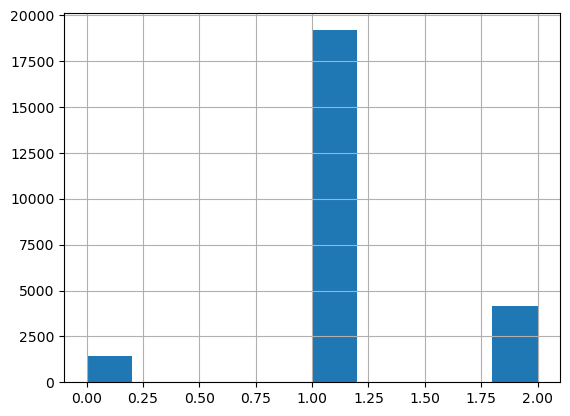

In [8]:
df['class'].hist()

This histogram shows the imbalanced nature of the task - most tweets containing "hate" words as defined by Hatebase were 
only considered to be offensive by the CF coders. More tweets were considered to be neither hate speech nor offensive language than were considered hate speech.

In [9]:
tweets=df.tweet

## Feature generation

In [10]:

stopwords=stopwords = nltk.corpus.stopwords.words("english")

other_exclusions = ["#ff", "ff", "rt"]
stopwords.extend(other_exclusions)

stemmer = PorterStemmer()


def preprocess(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, '', parsed_text)
    parsed_text = re.sub(mention_regex, '', parsed_text)
    return parsed_text

def tokenize(tweet):
    """Removes punctuation & excess whitespace, sets to lowercase,
    and stems tweets. Returns a list of stemmed tokens."""


    #############LINE FIXED: * REPLACED WITH +##################### PREVIOUS::: tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    tweet = " ".join(re.split("[^a-zA-Z]+", tweet.lower())).strip()
    tokens = [stemmer.stem(t) for t in tweet.split()]
    return tokens

def basic_tokenize(tweet):
    """Same as tokenize but without the stemming"""

    #############LINE FIXED: * REPLACED WITH +##################### PREVIOUS::: tweet = " ".join(re.split("[^a-zA-Z.,!?]*", tweet.lower())).strip()
    tweet = " ".join(re.split("[^a-zA-Z.,!?]+", tweet.lower())).strip()
    return tweet.split()

vectorizer = TfidfVectorizer(
    tokenizer=tokenize,
    preprocessor=preprocess,
    ngram_range=(1, 3),
    stop_words=stopwords,
    use_idf=True,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=10000,
    min_df=5,
    max_df=0.75
    )

In [11]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [12]:
#Construct tfidf matrix and get relevant scores
tfidf = vectorizer.fit_transform(tweets).toarray()
vocab = {v:i for i, v in enumerate(vectorizer.get_feature_names_out())}
idf_vals = vectorizer.idf_
idf_dict = {i:idf_vals[i] for i in vocab.values()} #keys are indices; values are IDF scores

/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'ani', 'becaus', 'befor', 'doe', 'dure', 'ha', 'hi', 'onc', 'onli', 'ourselv', 'themselv', 'thi', 'veri', 'wa', 'whi', 'yourselv'] not in stop_words.
  warnings.warn(


In [13]:
#Get POS tags for tweets and save as a string

tweet_tags = []
for t in tweets:
    tokens = basic_tokenize(preprocess(t))
    tags = nltk.pos_tag(tokens)
    tag_list = [x[1] for x in tags]
    tag_str = " ".join(tag_list)
    tweet_tags.append(tag_str)

In [14]:
#We can use the TFIDF vectorizer to get a token matrix for the POS tags
pos_vectorizer = TfidfVectorizer(
    tokenizer=None,
    lowercase=False,
    preprocessor=None,
    ngram_range=(1, 3),
    stop_words=None,
    use_idf=False,
    smooth_idf=False,
    norm=None,
    decode_error='replace',
    max_features=5000,
    min_df=5,
    max_df=0.75,
    )

In [15]:
#Construct POS TF matrix and get vocab dict
pos = pos_vectorizer.fit_transform(pd.Series(tweet_tags)).toarray()
pos_vocab = {v:i for i, v in enumerate(pos_vectorizer.get_feature_names_out())}

In [16]:
#Now get other features
sentiment_analyzer = VS()

def count_twitter_objs(text_string):
    """
    Accepts a text string and replaces:
    1) urls with URLHERE
    2) lots of whitespace with one instance
    3) mentions with MENTIONHERE
    4) hashtags with HASHTAGHERE

    This allows us to get standardized counts of urls and mentions
    Without caring about specific people mentioned.
    
    Returns counts of urls, mentions, and hashtags.
    """
    space_pattern = '\s+'
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    parsed_text = re.sub(space_pattern, ' ', text_string)
    parsed_text = re.sub(giant_url_regex, 'URLHERE', parsed_text)
    parsed_text = re.sub(mention_regex, 'MENTIONHERE', parsed_text)
    parsed_text = re.sub(hashtag_regex, 'HASHTAGHERE', parsed_text)
    return(parsed_text.count('URLHERE'),parsed_text.count('MENTIONHERE'),parsed_text.count('HASHTAGHERE'))

def other_features(tweet):
    """This function takes a string and returns a list of features.
    These include Sentiment scores, Text and Readability scores,
    as well as Twitter specific features"""
    sentiment = sentiment_analyzer.polarity_scores(tweet)
    
    words = preprocess(tweet) #Get text only
    
    syllables = textstat.syllable_count(words)
    num_chars = sum(len(w) for w in words)
    num_chars_total = len(tweet)
    num_terms = len(tweet.split())
    num_words = len(words.split())
    avg_syl = round(float((syllables+0.001))/float(num_words+0.001),4)
    num_unique_terms = len(set(words.split()))
    
    ###Modified FK grade, where avg words per sentence is just num words/1
    FKRA = round(float(0.39 * float(num_words)/1.0) + float(11.8 * avg_syl) - 15.59,1)
    ##Modified FRE score, where sentence fixed to 1
    FRE = round(206.835 - 1.015*(float(num_words)/1.0) - (84.6*float(avg_syl)),2)
    
    twitter_objs = count_twitter_objs(tweet)
    retweet = 0
    if "rt" in words:
        retweet = 1
    features = [FKRA, FRE,syllables, avg_syl, num_chars, num_chars_total, num_terms, num_words,
                num_unique_terms, sentiment['neg'], sentiment['pos'], sentiment['neu'], sentiment['compound'],
                twitter_objs[2], twitter_objs[1],
                twitter_objs[0], retweet]
    #features = pandas.DataFrame(features)
    return features

def get_feature_array(tweets):
    feats=[]
    for t in tweets:
        feats.append(other_features(t))
    return np.array(feats)

In [17]:
other_features_names = ["FKRA", "FRE","num_syllables", "avg_syl_per_word", "num_chars", "num_chars_total", \
                        "num_terms", "num_words", "num_unique_words", "vader neg","vader pos","vader neu", \
                        "vader compound", "num_hashtags", "num_mentions", "num_urls", "is_retweet"]

In [18]:
feats = get_feature_array(tweets)

In [19]:
#Now join them all up
M = np.concatenate([tfidf,pos,feats],axis=1)

In [20]:
M.shape

(24783, 11172)

In [21]:
#Finally get a list of variable names
variables = ['']*len(vocab)
for k,v in vocab.items():
    variables[v] = k

pos_variables = ['']*len(pos_vocab)
for k,v in pos_vocab.items():
    pos_variables[v] = k

feature_names = variables+pos_variables+other_features_names

# Running the model

In [22]:
X = pd.DataFrame(M)
y = df['class'].astype(int)

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [25]:
# Davidson et al. 2017 winner model

In [26]:
# CHANGE --> solver='liblinear' added for l1, otherwise won't work
select = SelectFromModel(LogisticRegression(class_weight='balanced',penalty="l1",C=0.01, solver='liblinear'))
X_ = select.fit_transform(X,y)

In [27]:
X__train, X__test, y__train, y__test = train_test_split(X_, y, random_state=42, test_size=0.1)

In [28]:
# CHANGE --> max_iter=10000 added for l2, otherwsie ConvergenceWarning: lbfgs failed to converge (status=1): STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.
model = LogisticRegression(class_weight='balanced',penalty='l2',C=0.01,  max_iter=10000).fit(X__train,y__train)

In [29]:
y__preds = model.predict(X__test)

In [30]:
report = classification_report( y__test, y__preds )

In [31]:
print(report)

              precision    recall  f1-score   support

           0       0.31      0.75      0.44       164
           1       0.98      0.83      0.90      1905
           2       0.81      0.93      0.87       410

    accuracy                           0.84      2479
   macro avg       0.70      0.84      0.73      2479
weighted avg       0.91      0.84      0.86      2479



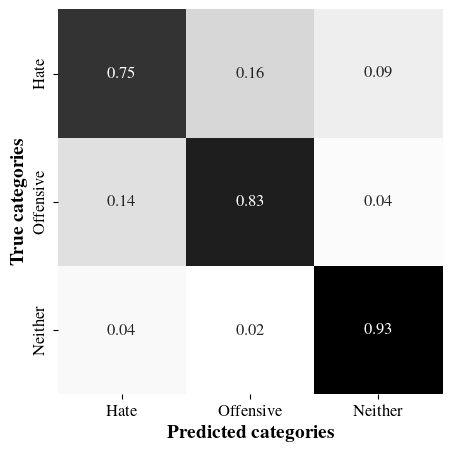

In [32]:
plt.rc('pdf', fonttype=42)
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['text.usetex'] = True
plt.rcParams['font.serif'] = 'Times'
plt.rcParams['font.family'] = 'serif'
from sklearn.metrics import confusion_matrix

confusion_matrix = confusion_matrix(y__test, y__preds)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'\textbf{True categories}',fontsize=14)
plt.xlabel(r'\textbf{Predicted categories}',fontsize=14)
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
#plt.savefig('confusion.pdf')

In [33]:
# tpot

In [34]:
!pip install tpot

In [35]:
from tpot import TPOTClassifier

/opt/conda/lib/python3.10/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [36]:
tpot = TPOTClassifier(generations=5, population_size=40, verbosity=2, random_state=42, scoring='f1_weighted')
tpot.fit(X_train, y_train)
print(tpot.score(X_test, y_test))
tpot.export('tpot_hsol_pipeline-pop-40.py')

Optimization Progress:   0%|          | 0/300 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8685160374053519

Generation 2 - Current best internal CV score: 0.8941806624535964

Generation 3 - Current best internal CV score: 0.8941806624535964

Generation 4 - Current best internal CV score: 0.8941806624535964

Generation 5 - Current best internal CV score: 0.8941806624535964

Best pipeline: DecisionTreeClassifier(LinearSVC(input_matrix, C=15.0, dual=False, loss=squared_hinge, penalty=l2, tol=0.01), criterion=entropy, max_depth=5, min_samples_leaf=2, min_samples_split=11)
0.8909740360913364


In [52]:
# winner tpot-pipeline 40
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MaxAbsScaler
from sklearn.svm import LinearSVC
from tpot.export_utils import set_param_recursive

training_features, testing_features, training_target, testing_target = \
            train_test_split(X, y, random_state=42)

# Average CV score on the training set was: 0.8947490662475207
exported_pipeline = make_pipeline(
    MaxAbsScaler(),
    LinearSVC(C=0.5, dual=False, loss="squared_hinge", penalty="l1", tol=0.0001)
)
# Fix random state for all the steps in exported pipeline
set_param_recursive(exported_pipeline.steps, 'random_state', 42)

exported_pipeline.fit(training_features, training_target)
results = exported_pipeline.predict(testing_features)

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


In [53]:
report = classification_report(testing_target, results)

In [54]:
print(report)

              precision    recall  f1-score   support

           0       0.48      0.29      0.36       361
           1       0.94      0.95      0.94      4794
           2       0.84      0.90      0.87      1041

    accuracy                           0.90      6196
   macro avg       0.75      0.71      0.72      6196
weighted avg       0.89      0.90      0.90      6196



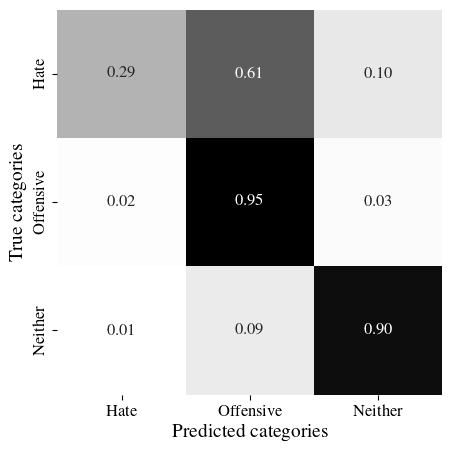

In [55]:
from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(testing_target, results)
matrix_proportions = np.zeros((3,3))
for i in range(0,3):
    matrix_proportions[i,:] = confusion_matrix[i,:]/float(confusion_matrix[i,:].sum())
names=['Hate','Offensive','Neither']
confusion_df = pd.DataFrame(matrix_proportions, index=names,columns=names)
plt.figure(figsize=(5,5))
seaborn.heatmap(confusion_df,annot=True,annot_kws={"size": 12},cmap='gist_gray_r',cbar=False, square=True,fmt='.2f')
plt.ylabel(r'True categories',fontsize=14)
plt.xlabel(r'Predicted categories',fontsize=14)
plt.tick_params(labelsize=12)

#Uncomment line below if you want to save the output
#plt.savefig('confusion.pdf')